# Ripple NRTidal verification notebook

**Abstract:** Here, we will write code that checks the implementation written for the NRTidal project.

*To Do:* 
- Check if we can verify with LAL instead of Bilby, since that's also done in the original ripple paper.
- Getting NaNs for equal mass?

In [334]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from jax import grad, vmap
from functools import partial
import importlib

import tqdm

import bilby

# To get the relevant plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

We will compare waveforms with the following intrinsic parameters:

In [335]:
m1 = 1.5 # masses
m2 = 1.5

chi1 = 0.01 # spins
chi2 = 0.02

lambda1 = 3500 # tidal deformabilities
lambda2 = 3500

distance = 50.

Get the frequency grid:

In [336]:
# Frequency grid

f_l = 16
f_u = 512
f_sampling = 2 * 4096

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]
f_ref = f_l

## Ripple

In [337]:
from ripple.waveforms import X_NRTidalv2
importlib.reload(X_NRTidalv2)

<module 'ripple.waveforms.X_NRTidalv2' from '/Users/Woute029/Documents/Code/ripple/src/ripple/waveforms/X_NRTidalv2.py'>

In [338]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0.0 
phic = 0.0
dist_mpc = distance
inclination = 0.0
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination, polarization_angle])

f_l = 16
f_u = 512
del_f = 0.01
T = 16
f_sampling = 4096
fs_ripple = jnp.arange(f_l, f_u, del_f)

# We also need to give a reference frequency - here, this will be the lower frequency
f_ref = f_l

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

10.688736
22.679537
10.688736
22.679537


## Bridging the gap between the two implementations

About the amplitude:
- Have to implement the Planck taper

About the phase:
- Check the corrections coming from SS

## Comparison with LAL

Check the LAL code (and also how to compute the mismatch between your waveform and LAL) in [this tutorial](https://github.com/tedwards2412/ripple/blob/main/test/check_waveform_match.py).

In [339]:
import lalsimulation as lalsim
import lal

from ripple import get_eff_pads, get_match_arr

In [340]:
IMRphenom = "IMRPhenomD_NRTidalv2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("/Users/Woute029/Documents/Code/ripple/test/O3Livingston.txt", unpack=True)

# Parameters
tc = 0.0
phic = 0.0
dist_mpc = 50
inclination = 0.0
phi_ref = 0.0

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

f_ref = f_l
m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

# Frequency grid

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]
f_ref = f_l

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phi_ref,
    0,
    lambda1,
    lambda2,
    del_f,
    f_l,
    f_u,
    f_ref,
    None,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * del_f

Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

theta_ripple = np.array(
    [Mc, eta, theta[2], theta[3], dist_mpc, tc, phic, inclination]
)
# hp_ripple = waveform(theta_ripple)
pad_low, pad_high = get_eff_pads(fs)
PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

Plot

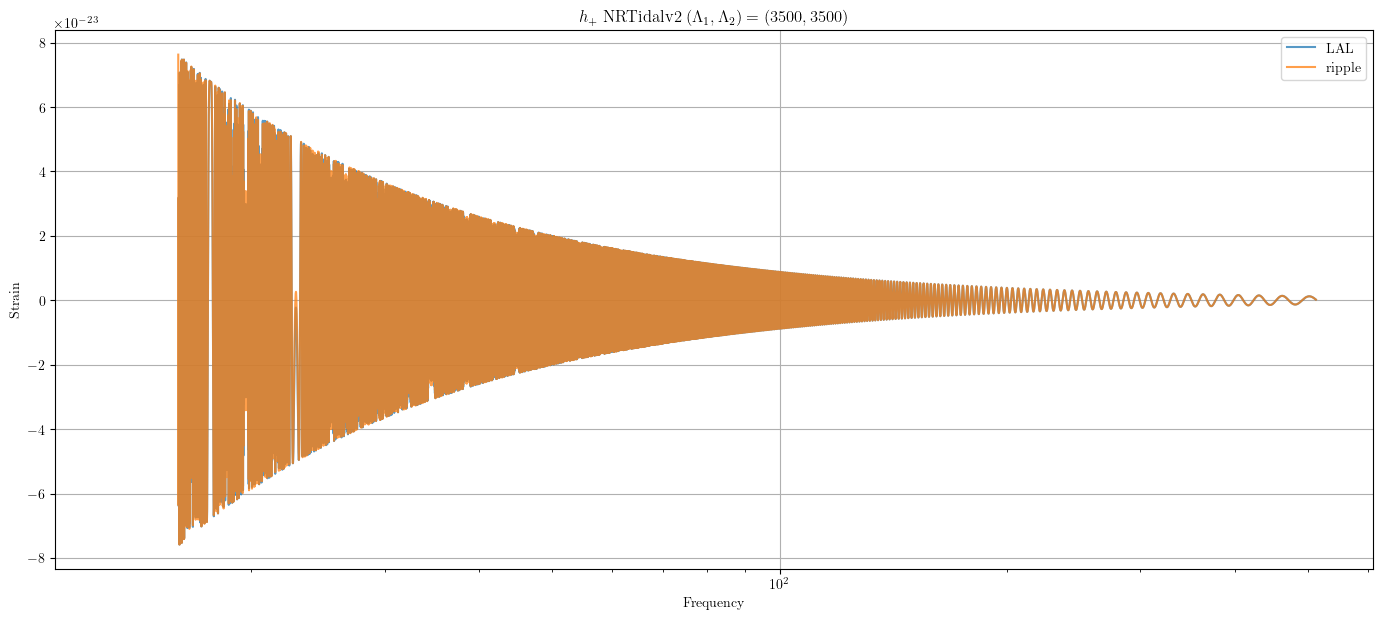

In [341]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(freqs_lal[mask_lal], hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(fs_ripple, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()

Get the merger frequency

In [342]:
f_merger = X_NRTidalv2._get_f_merger(jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))
f_merger = float(f_merger)
f_merger

6876.5224609375

Check the amplitude and the phase separately

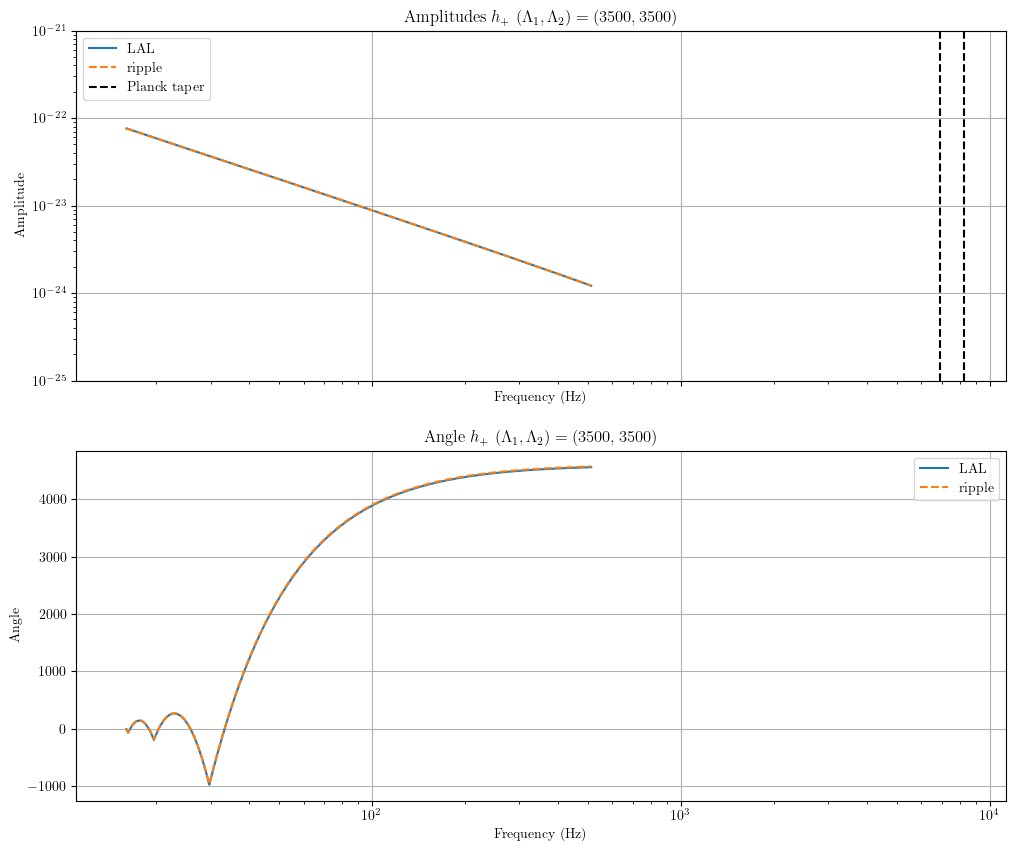

In [343]:
A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite)) #% (2 * np.pi)
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple)) #% (2 * np.pi)
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-25, 1e-21)
plt.xlim(f_l - 5)
plt.legend()



# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

## Waveform check

**TODO** Finish.

To be completely consistent with ripple, we will use lal to check the waveform match

In [344]:
# def random_match_waveforms(n, IMRphenom: str = "IMRPhenom_NRTidalv2"):
#     # Get a frequency domain waveform
#     f_l = 24
#     f_u = 1024
#     T = 16
    
#     f_sampling = 4096
#     delta_t = 1 / f_sampling
#     tlen = int(round(T / delta_t))
#     freqs = np.fft.rfftfreq(tlen, delta_t)
#     df = freqs[1] - freqs[0]
#     fs = freqs[(freqs > f_l) & (freqs < f_u)]
#     f_ref = f_l

#     @jax.jit
#     def waveform(theta):
#         hp, _ = X_NRTidalv2.gen_NRTidalv2_hphc(fs, theta_ripple, f_ref)
#         return hp

#     # Get a frequency domain waveform
#     thetas = []
#     matches = []
#     f_ASD, ASD = np.loadtxt("/Users/Woute029/Documents/Code/ripple/test/O3Livingston.txt", unpack=True)

#     if "PhenomP" in IMRphenom:
#         for i in tqdm(range(n)):
#             precessing_matchmaking(
#                 IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
#             )
#     else:
#         for i in tqdm(range(n)):
#             non_precessing_matchmaking(
#                 IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
#             )

#     thetas = np.array(thetas)
#     matches = np.array(matches)
#     # print(thetas, matches)
#     print("Mean match:", np.mean(matches))
#     print("Median match:", np.median(matches))
#     print("Minimum match:", np.min(matches))

#     return None


# def non_precessing_matchmaking(
#     IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
# ):
#     m1 = np.random.uniform(1.0, 100.0)
#     m2 = np.random.uniform(1.0, 100.0)
#     s1 = np.random.uniform(-1.0, 1.0)
#     s2 = np.random.uniform(-1.0, 1.0)

#     tc = 0.0
#     phic = 0.0
#     dist_mpc = 440
#     inclination = np.pi / 2.0
#     phi_ref = 0.0

#     if m1 < m2:
#         theta = np.array([m2, m1, s2, s1, dist_mpc, tc, phic, inclination])
#     elif m1 > m2:
#         theta = np.array([m1, m2, s1, s2, dist_mpc, tc, phic, inclination])
#     else:
#         raise ValueError("Something went wrong with the parameters")
#     approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

#     f_ref = f_l
#     m1_kg = theta[0] * lal.MSUN_SI
#     m2_kg = theta[1] * lal.MSUN_SI
#     distance = dist_mpc * 1e6 * lal.PC_SI

#     hp, _ = lalsim.SimInspiralChooseFDWaveform(
#         m1_kg,
#         m2_kg,
#         0.0,
#         0.0,
#         theta[2],
#         0.0,
#         0.0,
#         theta[3],
#         distance,
#         inclination,
#         phi_ref,
#         0,
#         0.0,
#         0.0,
#         df,
#         f_l,
#         f_u,
#         f_ref,
#         None,
#         approximant,
#     )
#     freqs_lal = np.arange(len(hp.data.data)) * df

#     Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

#     theta_ripple = np.array(
#         [Mc, eta, theta[2], theta[3], dist_mpc, tc, phic, inclination]
#     )
#     hp_ripple = waveform(theta_ripple)
#     pad_low, pad_high = get_eff_pads(fs)
#     PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

#     mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
#     hp_lalsuite = hp.data.data[mask_lal]
#     matches.append(
#         get_match_arr(
#             pad_low,
#             pad_high,
#             # np.ones_like(fs) * 1.0e-42,
#             PSD_vals,
#             hp_ripple,
#             hp_lalsuite,
#         )
#     )
#     thetas.append(theta)


# def precessing_matchmaking(
#     IMRphenom, f_l, f_u, df, fs, waveform, f_ASD, ASD, thetas, matches
# ):
#     m1 = np.random.uniform(1.0, 100.0)
#     m2 = np.random.uniform(1.0, 100.0)
#     s1_amp = np.random.uniform(0.0, 1.0)
#     s2_amp = np.random.uniform(0.0, 1.0)
#     s1_phi = np.random.uniform(0, 2 * np.pi)
#     s2_phi = np.random.uniform(0, 2 * np.pi)
#     s1_thetahelper = np.random.uniform(0, 1)
#     s2_thetahelper = np.random.uniform(0, 1)
#     s1_theta = np.arccos(1 - 2 * s1_thetahelper)
#     s2_theta = np.arccos(1 - 2 * s2_thetahelper)
#     # translate that into cartesian
#     s1x = s1_amp * np.sin(s1_theta) * np.cos(s1_phi)
#     s1y = s1_amp * np.sin(s1_theta) * np.sin(s1_phi)
#     s1z = s1_amp * np.cos(s1_theta)

#     s2x = s2_amp * np.sin(s2_theta) * np.cos(s2_phi)
#     s2y = s2_amp * np.sin(s2_theta) * np.sin(s2_phi)
#     s2z = s2_amp * np.cos(s2_theta)

#     tc = 0.0
#     phic = 0.0
#     dist_mpc = 440
#     inclination = np.pi / 2.0
#     phi_ref = 0

#     if m1 < m2:
#         theta = np.array(
#             [m2, m1, s2x, s2y, s2z, s1x, s1y, s1z, dist_mpc, tc, phi_ref, inclination]
#         )
#     elif m1 > m2:
#         theta = np.array(
#             [m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, dist_mpc, tc, phi_ref, inclination]
#         )
#     else:
#         raise ValueError("Something went wrong with the parameters")
#     approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

#     f_ref = f_l
#     m1_kg = theta[0] * lal.MSUN_SI
#     m2_kg = theta[1] * lal.MSUN_SI
#     distance = dist_mpc * 1e6 * lal.PC_SI

#     hp, _ = lalsim.SimInspiralChooseFDWaveform(
#         m1_kg,
#         m2_kg,
#         theta[2],
#         theta[3],
#         theta[4],
#         theta[5],
#         theta[6],
#         theta[7],
#         distance,
#         inclination,
#         phi_ref,
#         0,
#         0.0,
#         0.0,
#         df,
#         f_l,
#         f_u,
#         f_ref,
#         None,
#         approximant,
#     )
#     freqs_lal = np.arange(len(hp.data.data)) * df

#     Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
#     theta_ripple = np.array(
#         [
#             Mc,
#             eta,
#             theta[2],
#             theta[3],
#             theta[4],
#             theta[5],
#             theta[6],
#             theta[7],
#             dist_mpc,
#             tc,
#             phic,
#             inclination,
#         ]
#     )
#     hp_ripple = waveform(theta_ripple)
#     pad_low, pad_high = get_eff_pads(fs)
#     PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

#     mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
#     hp_lalsuite = hp.data.data[mask_lal]
#     matches.append(
#         get_match_arr(
#             pad_low,
#             pad_high,
#             # np.ones_like(fs) * 1.0e-42,
#             PSD_vals,
#             hp_ripple,
#             hp_lalsuite,
#         )
#     )
#     thetas.append(theta)


# if __name__ == "__main__":
#     # Choose from "IMRPhenomD", "IMRPhenomXAS", "IMRPhenomPv2"
#     random_match_waveforms(1000, "IMRPhenomXAS")
#     None